In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter,OrderedDict

### Data preparation

In [2]:
communication=pd.read_csv('dataset/communication.csv',sep=';')
reports_to=pd.read_csv('dataset/reportsto.csv',sep=';')

In [3]:
## UPPER_MANAGEMENT_TEAM - 0, MID_MANAGEMENT_TEAM - 1, OTHERS - 2 
UPPER_MANAGEMENT_TEAM=[86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
MID_MANAGEMENT_TEAM=[76, 90, 136, 137, 143, 152, 47, 162]

In [4]:
def prepare_user_label_info():
    def get_label(user):
        if user in UPPER_MANAGEMENT_TEAM:
            return 0
        elif user in MID_MANAGEMENT_TEAM:
            return 1
        else:
            return 2
    source=communication.Sender.to_list()
    target=communication.Recipient.to_list()
    all_users=[]
    all_users.extend(source)
    all_users.extend(target)
    all_users=list(set(all_users))
    user_lables=[get_label(user) for user in all_users]
    return all_users,user_lables

In [5]:
ALL_USERS,ALL_LABELS=prepare_user_label_info()
ALL_USERS_COUNT=len(ALL_USERS)

In [6]:
def prepare_communication_graph():
    source=communication.Sender.to_list()
    target=communication.Recipient.to_list()
    network = pd.DataFrame(list(zip(source, target)), 
           columns =['source', 'target'])
    return nx.convert_matrix.from_pandas_edgelist(network,create_using=nx.DiGraph())
def prepare_reports_to_graph():
    source=reports_to.ID.to_list()
    target=reports_to.ReportsToID.to_list()
    network = pd.DataFrame(list(zip(source, target)), 
           columns =['source', 'target'])
    return nx.convert_matrix.from_pandas_edgelist(network,create_using=nx.DiGraph())

GRAPH_COMMUNICATION=prepare_communication_graph()
GRAPH_REPORTS=prepare_reports_to_graph()

### Graph independent features

In [7]:
def node_independant_features(nodes):
    pr = nx.pagerank(GRAPH_COMMUNICATION)
    in_degree=nx.in_degree_centrality(GRAPH_COMMUNICATION)
    out_degree=nx.out_degree_centrality(GRAPH_COMMUNICATION)
    degree=nx.degree_centrality(GRAPH_COMMUNICATION)
    closeness=nx.closeness_centrality(GRAPH_COMMUNICATION)
    betweeness=nx.betweenness_centrality(GRAPH_COMMUNICATION)
    all_features=[]
    for node in nodes:
        node_features=[pr[node],betweeness[node],in_degree[node],out_degree[node],degree[node],closeness[node]]
        all_features.append(np.asarray(node_features))
    return np.asarray(all_features)

In [8]:
INDEPENDENT_FATURES=node_independant_features(ALL_USERS)
INDEPENDENT_FATURES_DF = pd.DataFrame(INDEPENDENT_FATURES,columns=['pr','bet','in','out','deg','cl'])

### Ranking functions

In [9]:
def betweeness_split(percentage):
    known=INDEPENDENT_FATURES_DF.sort_values(by='bet',ascending=False)[0:int(ALL_USERS_COUNT*percentage)].index.to_list()
    unknown=[user for user in ALL_USERS if user not in known]
    return known,unknown

In [10]:
def pagerank_split(percentage):
    known=INDEPENDENT_FATURES_DF.sort_values(by='pr',ascending=False)[0:int(ALL_USERS_COUNT*percentage)].index.to_list()
    unknown=[user for user in ALL_USERS if user not in known]
    return known,unknown

In [11]:
def degree_split(percentage):
    known=INDEPENDENT_FATURES_DF.sort_values(by='deg',ascending=False)[0:int(ALL_USERS_COUNT*percentage)].index.to_list()
    unknown=[user for user in ALL_USERS if user not in known]
    return known,unknown

In [12]:
def stratified_split(percentage):
    x_unknown, x_known= train_test_split(ALL_USERS,test_size=percentage,stratify=ALL_LABELS)
    return x_known,x_unknown

In [13]:
def get_train_xs_ys(features,known):
    res_features=[]
    res_labels=[]
    for user in known:
        res_features.append(features[user-1])
        res_labels.append(ALL_LABELS[user-1])
    return np.asarray(res_features),res_labels

### Dependant features

In [86]:
def get_node_neighbourhood_stats(node,G,known, unknown,current_unknown_labels):
    def check_neighbour(neighbour):
        if neighbour in known:
            return ALL_LABELS[neighbour-1]
        else:
            return current_unknown_labels[unknown.index(neighbour)]
    neighbours=[n for n in G.neighbors(node)]
    counters=[0,0,0,0]
    for neighbour in neighbours:
        ind=check_neighbour(neighbour)
        counters[ind]=counters[ind]+1
    return np.asarray(counters[0:-1])

In [87]:
def node_dependant_features(nodes,G,known, unknown,current_unknown_labels):
    all_features=[]
    for node in nodes:
        node_features=get_node_neighbourhood_stats(node,G,known, unknown,current_unknown_labels)
        all_features.append(node_features)
    return np.asarray(all_features)



In [88]:
def node_dependant_independant_features(nodes,G,known, unknown,current_unknown_labels):
    dependant=node_dependant_features(nodes,G,known, unknown,current_unknown_labels)
    return np.concatenate((dependant,INDEPENDENT_FATURES),axis=1)
# node_dependant_independant_features(all_users,GRAPH_COMMUNICATION,X_known, X_unknown)

### Classifiers

In [89]:
def svm_classifier(x_train,y_train):
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    return clf

In [90]:
def naive_bayes_classifier(x_train,y_train):
    clf = GaussianNB()
    clf.fit(x_train,y_train)
    return clf

In [91]:
def mlp_classifier(x_train,y_train):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(x_train,y_train)
    return clf

In [92]:
def decision_tree_classifier(x_train,y_train):
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x_train,y_train)
    return clf

In [93]:
def random_forrest_classifier(x_train,y_train):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(x_train,y_train)
    return clf

In [94]:
def boosting_classifier(x_train,y_train):
    clf = GradientBoostingClassifier()
    clf.fit(x_train,y_train)
    return clf

### ICM 

In [107]:
def prepare_data_icm(features_type='DEP',split_func=pagerank_split,percentage=0.3,classifier_func=decision_tree_classifier):
    known, unknown=split_func(percentage)
    current_unknown_labels=[3 for i in range(len(unknown))]
    if features_type == 'DEP':
        features=node_dependant_features(ALL_USERS,GRAPH_COMMUNICATION,known, unknown,current_unknown_labels)
        features_func=node_dependant_features
    else:
        features=node_dependant_independant_features(ALL_USERS,GRAPH_COMMUNICATION,known, unknown,current_unknown_labels)
        features_func=node_dependant_independant_features
    x_train, y_train=get_train_xs_ys(features,known)
    if len(set(y_train)) == 1:
        y_train[-1]=(y_train[-1]+1)%3
    clf=classifier_func(x_train, y_train)
    return known, unknown, features, clf,features_func,x_train, y_train

In [112]:
def icm_loop(known, unknown, features, clf,features_func, max_iter=100):
    current_unknown_labels=[3 for i in range(len(unknown))]
    for i in range(max_iter):
        for node in unknown:
            pred=clf.predict([features[node-1]])[0]
            current_unknown_labels[unknown.index(node)]=pred
            ##update features
            features=features_func(ALL_USERS,GRAPH_COMMUNICATION,known,unknown,current_unknown_labels)
    return current_unknown_labels,unknown,known

In [113]:
def evaluate_f1(unknown_labels,unknown):
    predictions=ALL_LABELS.copy()
    for i in range (len(unknown_labels)):
        predictions[unknown[i]-1]=unknown_labels[i]
    return f1_score(ALL_LABELS, predictions,average='macro'), accuracy_score(ALL_LABELS, predictions),predictions

In [114]:
def evaluate_f1_unknown(unknown_labels,unknown):
    true_labels=[]
    for i in range (len(unknown_labels)):
        true_labels.append(ALL_LABELS[unknown[i]-1])
    return f1_score(true_labels, unknown_labels,average='macro'), accuracy_score(true_labels, unknown_labels),unknown_labels

In [116]:
known, unknown, features, clf,features_func,x_train, y_train=prepare_data_icm(percentage=0.1,features_type='DEP',split_func=betweeness_split,classifier_func=svm_classifier)
unknown_labels,unknown,known=icm_loop(known, unknown, features, clf,features_func,15)
f1,acc,predictions=evaluate_f1_unknown(unknown_labels,unknown)
print(acc,f1)



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8741721854304636 0.31095406360424027


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Experiments 

In [117]:
def run_tests_cnn(file_name):
    DF_COLUMNS = ['FEATURE_SET','PERCENTAGE','RANKING', 'CLASSIFIER','F1','ACC','F1_U','ACC_U']
    FEATURES_TYPES = ['DEP','INDEP']
    PERCENTAGE=[0.1, 0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    SPLIT_FUNCTIONS=[betweeness_split, pagerank_split,degree_split,stratified_split]
    SPLIT_LABELS=['betweeness', 'pagerank','degree','stratified']
    CLASSIFIERS=[random_forrest_classifier,decision_tree_classifier,mlp_classifier,naive_bayes_classifier,svm_classifier,boosting_classifier]
    CLASSIFIERS_LABELS=['random forrest','decision tree','mlp','NB','SVM','boosting']


    df = pd.DataFrame(columns=DF_COLUMNS)
    df.to_csv(file_name + '.csv',index=False)
    
    for feature_type in FEATURES_TYPES:
        for percentage in PERCENTAGE:
            for split_fun in SPLIT_FUNCTIONS:
                split_desc=SPLIT_LABELS[SPLIT_FUNCTIONS.index(split_fun)]
                for classifier in CLASSIFIERS:
                    classifier_desc=CLASSIFIERS_LABELS[CLASSIFIERS.index(classifier)]
                    known, unknown, features, clf,features_func,x_train, y_train=prepare_data_icm(percentage=percentage,features_type=feature_type,split_func=split_fun,classifier_func=classifier)
                    unknown_labels,unknown,known=icm_loop(known, unknown, features, clf,features_func,8)
                    
                    f1,acc,p=evaluate_f1(unknown_labels,unknown)
                    f1_u,acc_u,p=evaluate_f1_unknown(unknown_labels,unknown)

                    subdf=pd.DataFrame(zip([feature_type],[percentage],[split_desc],[classifier_desc],[f1],[acc],[f1_u],[acc_u]),
                                       columns=DF_COLUMNS)
                    subdf.to_csv(file_name + '.csv', mode='a',
                                 header=False, index=False)

In [118]:
run_tests_cnn('test_2')

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: U

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/ana

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: U

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anacond

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/ana

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anacond

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of ga

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: U

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/ana

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/ana

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anacond

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: T

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-d

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetri

### Visualizations

In [119]:
resarch_results = pd.read_csv('test_2.csv')

In [120]:
resarch_results.sort_values(by=['F1'], ascending=False)

,FEATURE_SET,PERCENTAGE,RANKING,CLASSIFIER,F1,ACC,F1_U,ACC_U
195,DEP,0.9,betweeness,NB,0.984377,0.994012,0.817204,0.941176
192,DEP,0.9,betweeness,random forrest,0.984377,0.994012,0.817204,0.941176
409,INDEP,0.9,betweeness,decision tree,0.984377,0.994012,0.817204,0.941176
193,DEP,0.9,betweeness,decision tree,0.984377,0.994012,0.817204,0.941176
413,INDEP,0.9,betweeness,boosting,0.984377,0.994012,0.817204,0.941176
...,...,...,...,...,...,...,...,...
224,INDEP,0.1,pagerank,mlp,0.312102,0.880240,0.309693,0.867550
223,INDEP,0.1,pagerank,decision tree,0.312102,0.880240,0.309693,0.867550
11,DEP,0.1,pagerank,boosting,0.312102,0.880240,0.309693,0.867550
222,INDEP,0.1,pagerank,random forrest,0.309829,0.868263,0.307143,0.854305


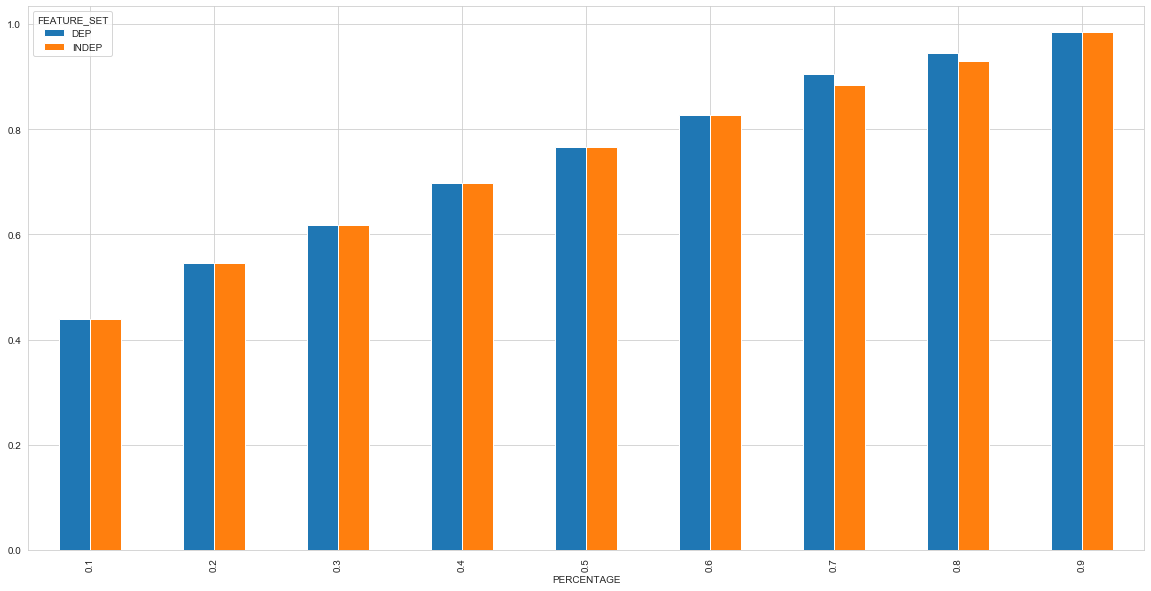

In [131]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
resarch_results.groupby(['PERCENTAGE','FEATURE_SET',]).max()['F1'].unstack().plot.bar(ax=ax)

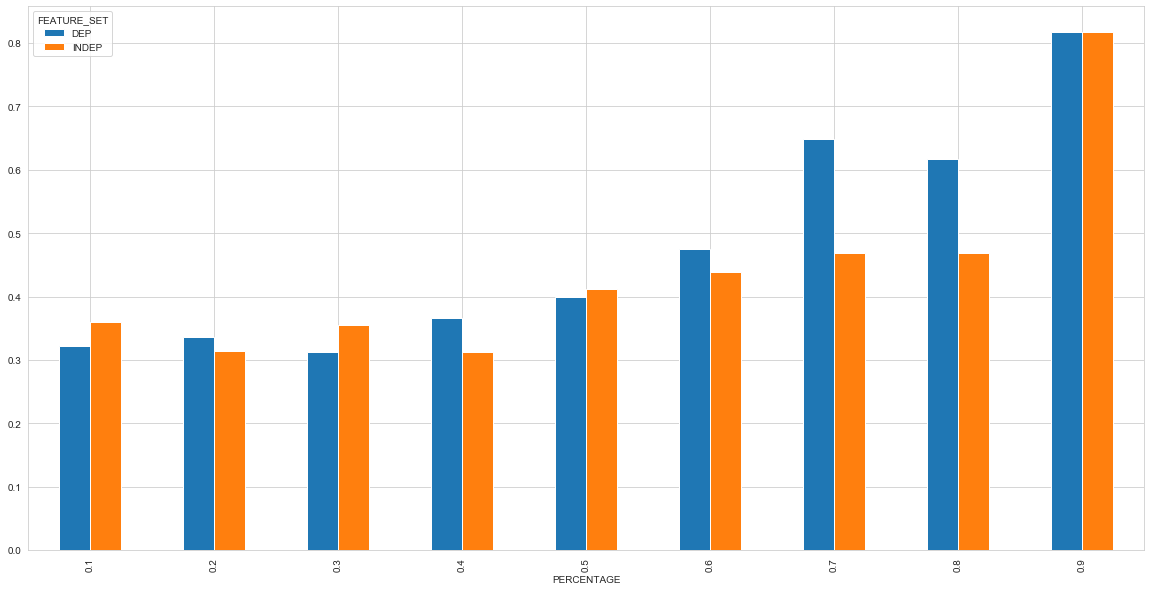

In [124]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
resarch_results.groupby(['PERCENTAGE','FEATURE_SET',]).max()['F1_U'].unstack().plot.bar(ax=ax)

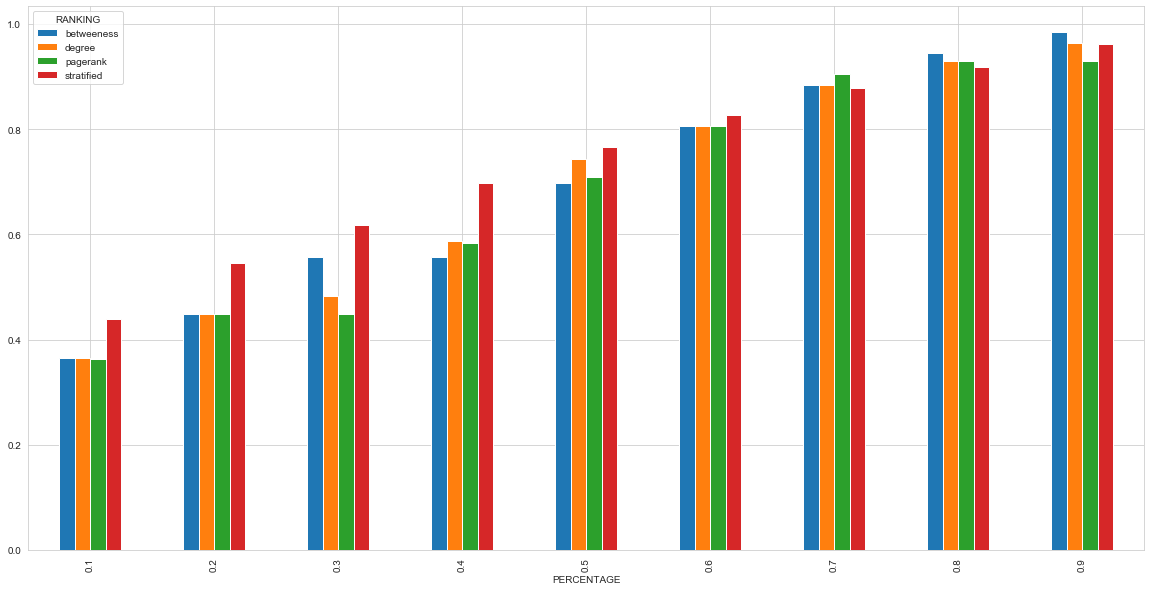

In [132]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
resarch_results.groupby(['PERCENTAGE','RANKING',]).max()['F1'].unstack().plot.bar(ax=ax)

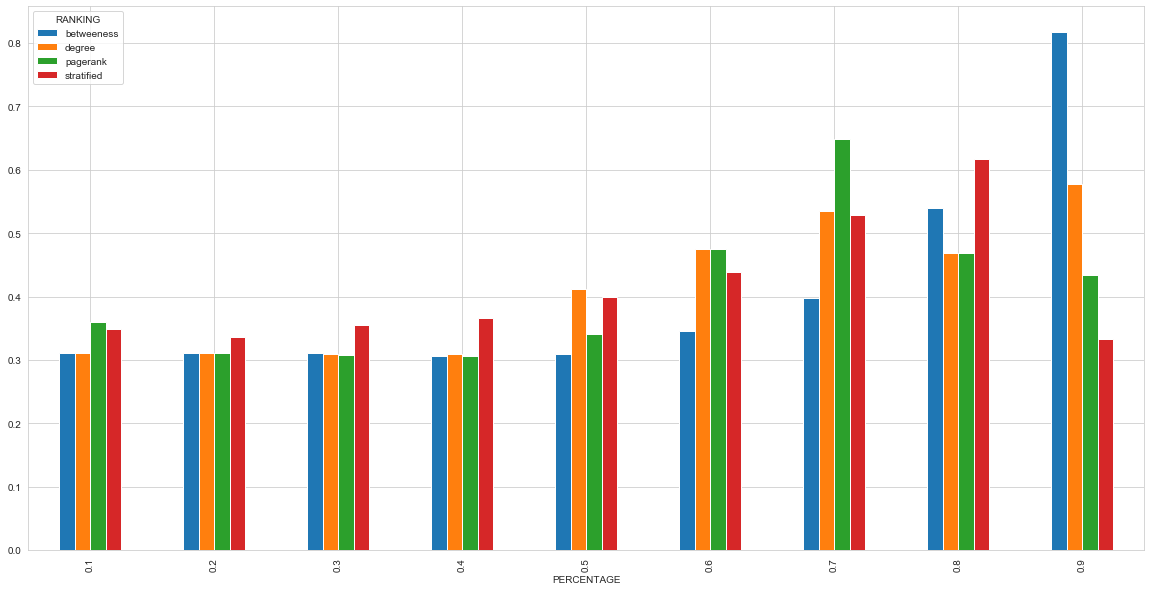

In [125]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
resarch_results.groupby(['PERCENTAGE','RANKING',]).max()['F1_U'].unstack().plot.bar(ax=ax)

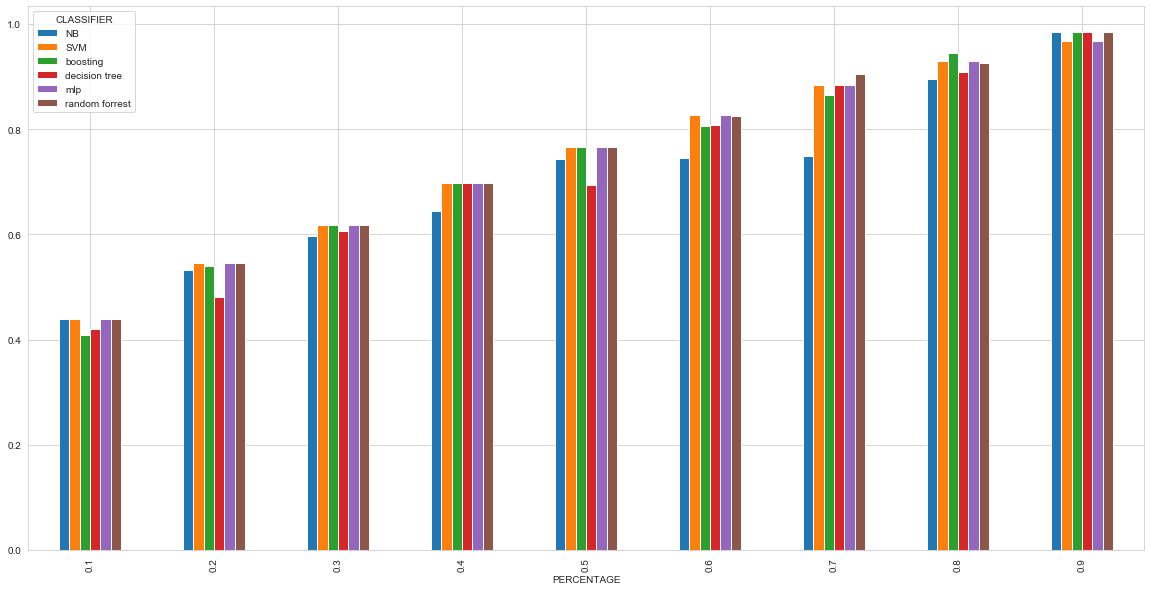

In [133]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
resarch_results.groupby(['PERCENTAGE','CLASSIFIER',]).max()['F1'].unstack().plot.bar(ax=ax)

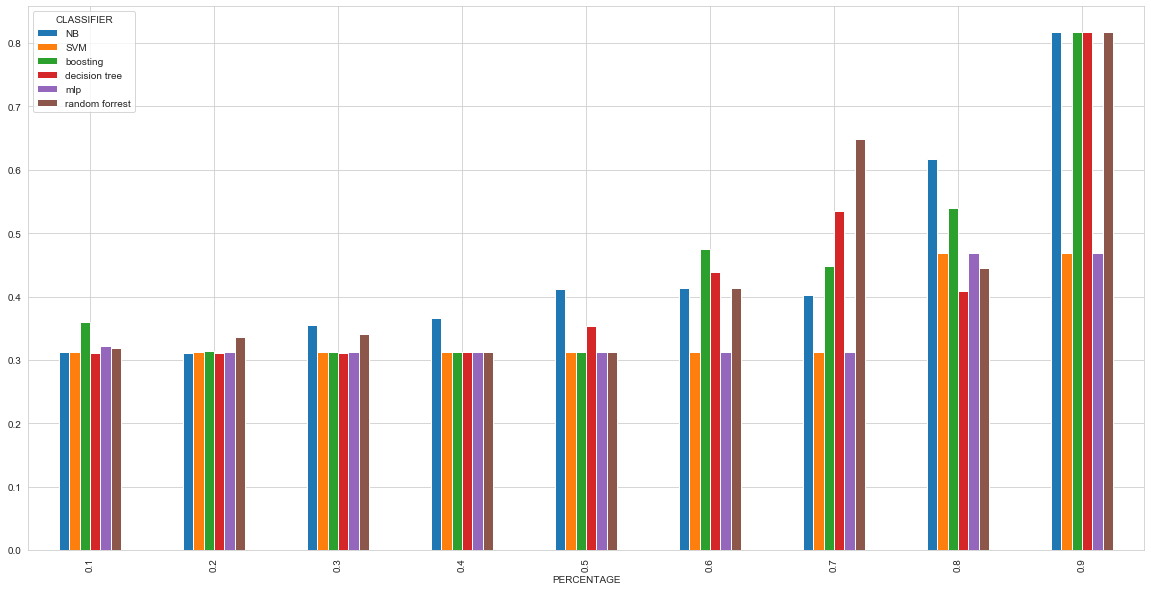

In [127]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
resarch_results.groupby(['PERCENTAGE','CLASSIFIER',]).max()['F1_U'].unstack().plot.bar(ax=ax)

#### Outcomes
On average, local classifiers that took into account features dependent only on the neighbors performed better, the utility socre metrics using rankings behaved differently depending on the percentage of labels initially exposed - the most reliable results were obtained by creating rankings and grading. Decision trees, random forrest and gradient boosting and Naive Bayes fared best as local classifier.

In [134]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

### Other algorithms (K-MEANS, KNN)

In [135]:
def k_means_result(x_train):
    def translate_k_means_preds(pred_k_means):
        values_counts=Counter(pred_k_means)
        sorted_x = sorted(values_counts.items(), key=lambda kv: kv[1])
        sorted_dict = OrderedDict(sorted_x)
        swap_dict = dict(zip(sorted_dict.keys(), [1,0,2])) 
        return [swap_dict[elem] for elem in pred_k_means]
    kmeans = KMeans(n_clusters=3, random_state=0).fit(x_train)
    predictions_k_means=translate_k_means_preds(kmeans.predict(features))
    return f1_score(ALL_LABELS, predictions_k_means,average='macro'), accuracy_score(ALL_LABELS, predictions_k_means)

def knn_result(x_train, y_train):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(x_train, y_train)
    knn_predictions=neigh.predict(features)
    return f1_score(ALL_LABELS, knn_predictions,average='macro'), accuracy_score(ALL_LABELS, knn_predictions)

### Best model - comparison with K-MEANS and KNN

#### Percentage 0.2

In [136]:
known, unknown, features, clf,features_func,x_train, y_train=prepare_data_icm(percentage=0.2,features_type='DEP',split_func=betweeness_split,classifier_func=svm_classifier)
unknown_labels,unknown,known=icm_loop(known, unknown, features, clf,features_func,10)
acc,f1,predictions=evaluate_f1(unknown_labels,unknown)
print(acc,f1)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.44844587352625936 0.8982035928143712


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
k_means_result(x_train)

(0.2682900432900433, 0.5149700598802395)

In [138]:
knn_result(x_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.3121019108280255, 0.8802395209580839)

#### Outcome
ICM alghorithm performs much better than cliustering alghoritms.


#### Percentage 0.5

In [139]:
known, unknown, features, clf,features_func,x_train, y_train=prepare_data_icm(percentage=0.5,features_type='DEP',split_func=degree_split,classifier_func=mlp_classifier)
unknown_labels,unknown,known=icm_loop(known, unknown, features, clf,features_func,10)
acc,f1,predictions=evaluate_f1(unknown_labels,unknown)
print(acc,f1)

0.7396121290046073 0.9341317365269461


In [140]:
k_means_result(x_train)

(0.2263990863109806, 0.4251497005988024)

In [141]:
knn_result(x_train,y_train)

(0.5127035830618892, 0.8862275449101796)

[[  5   0   7]
 [  0   4   4]
 [  0   0 147]]


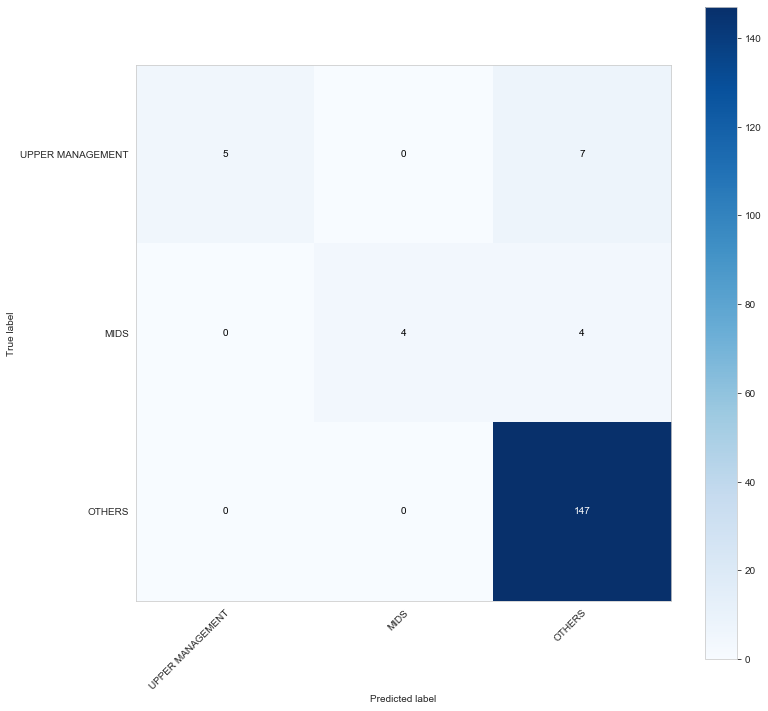

In [142]:
visualize_confusion_matrix(ALL_LABELS,predictions,['UPPER MANAGEMENT','MIDS','OTHERS'])

### Outcome
With bigger percentage of intitialy know labels ICA alghoritms performs obviously much better. 